In [1]:
# DATA
import numpy as np
import sklearn
import sklearn.cluster
import sklearn.model_selection
import pandas as pd
from IPython.display import display
import random
#PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# MISC
import os
import traceback
from datetime import datetime, timedelta
import warnings
import yaml
# UTIL
import util.intracluster_smote as intracluster_smote
import util.evaluation as evaluation
# DATASET UTIL
import util.dataset.mnist_utils as mnist_utils
import util.dataset.asirra_utils as asirra_utils
# AUTOENCODER
from keras.callbacks import TensorBoard
from keras.layers import advanced_activations
# Fixup for keras for Tensorboard > 0.12
import tensorflow as tf
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter
import util.autoencoder_keras as autoencoder_keras

Using TensorFlow backend.


In [2]:
# generate a session_id as a folder name to save run results
if 'session_id' not in globals():
    session_id = (datetime.utcnow() + timedelta(hours=2,minutes=0)).strftime("%Y-%m-%d %Hh%M")

In [3]:
# Exeriment Parameters
experiment_params = {
    'session_id': session_id,
    'random_seed': int(os.urandom(1)[0] / 255 * (2**32)), # unsigned 32-bit int between 0 and 2**32
    'SMOTE_k': 5,
    'Creditcard Fraud': {
        'k':1000,
        # KMEANS
        'kmeans_n_init':3,
        # AE
        'ae_layers': [30,2,30],
        'ae_n_epoch': 100,
        'ae_n_init':50,
        'ae_optimizer': 'adagrad',
        'ae_batch_size': 1000,
        'ae_default_activation_fn': advanced_activations.LeakyReLU,
        'ae_default_activation_fn_params': {'alpha': 0.01}
    }
}
np.random.seed(experiment_params['random_seed'])
random.seed(experiment_params['random_seed'])

# generate a session folder
if session_id not in os.listdir('results'):
    os.mkdir('results/{0}'.format(session_id))

# save experiment parameters
with open('results/{0}/experiment_parameters.yml'.format(session_id), 'w') as outfile:
    yaml.dump(experiment_params, outfile, default_flow_style=False, allow_unicode=True)

# Clustering Algorithms
These algorithms are used to cluster the dataset. Their output will later serve as input to Intracluster SMOTE to generate artificial data.

In [4]:
def kmeans(X,k,X_test):
#     if X.shape[0] < 5000: # 10000 recommended
#         return sklearn.cluster.KMeans(n_clusters=k).fit(X).labels_
#     else:
    try:
        return (
            X, 
            sklearn.cluster.MiniBatchKMeans(n_clusters=k, init_size=min(2*k, X.shape[0]), n_init=experiment_params[dataset_name]['kmeans_n_init']).fit(X).labels_,
            None, 
            {}
        )
    except Exception as e:
        np.save('results/{0}/{1}/{2}/error_data'.format(session_id, dataset_name,fold),X)
        raise e
        

In [5]:
# Define Clustering on Autoencoder Encoding
def autoencoder_kmeans(X,k,X_test):
    dim = X.shape[1]
    ae = autoencoder_keras.Autoencoder(
#         layers=[X.shape[1],128,64,min(32,X.shape[1]),64,128,X.shape[1]],    
        # reduce dimensions by increasing fractions, but always retain at least 5,4,3 features for low dimensional datasets
        # asirra 100x100x3: 3000, 1500, 750, 375, ..., 3000
        # mnist 28x28: 784, 392, 196, 98, ..., 784
        # ecoli: 7, 6, 5, 5, ..., 7 # don't use anymore - dataset too small
        # cc: 30, 15, 15, 10, ..., 30
#         layers=[dim, max(dim//2,15), max(dim//4,15), max(dim//8,10), max(dim//4,15), max(dim//2,15),dim], 
        layers=experiment_params[dataset_name]['ae_layers'], # optimized for cc
        optimizer=experiment_params[dataset_name]['ae_optimizer'],  # optimized for cc
        training_set=X,
        n_init = experiment_params[dataset_name]['ae_n_init'],
        default_activation_fn = experiment_params[dataset_name]['ae_default_activation_fn'](**experiment_params[dataset_name]['ae_default_activation_fn_params'])
    )
    ae.fit(X, X,
            nb_epoch=experiment_params[dataset_name]['ae_n_epoch'], # optimized for cc
            batch_size=experiment_params[dataset_name]['ae_batch_size'], # optimized for cc
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./results/{0}/{1}/{2}/{3}'.format(session_id,dataset_name,fold,'k-means_on_autoencoder_encoding')))]
    )
    np.save(
        'results/{0}/{1}/{2}/{3}/ae_weights'.format(session_id, dataset_name,fold,'k-means_on_autoencoder_encoding'),
        ae.get_parameters()
    )
    H = ae.encode(X)
    _, clusters, _, additional_benchmark_fields = kmeans(H,k,X_test)
    additional_benchmark_fields['AE Loss CE'] = ae.get_cost()
    additional_benchmark_fields['AE Loss MSE'] = np.mean((X - ae.decode(ae.encode(X)))**2)
    additional_benchmark_fields['AE Loss CE Validation'] = ae.get_cost(data=X_test)
    additional_benchmark_fields['AE Loss MSE Validation'] = np.mean((X_test - ae.decode(ae.encode(X_test)))**2)
    return (H, clusters, ae.decode, additional_benchmark_fields)

In [6]:
# Define Clustering on Autoencoder Encoding, returning unencoded X only
def autoencoder_kmeans_unencoded(X,k,X_test):
    dim = X.shape[1]
    ae = autoencoder_keras.Autoencoder(
        layers=experiment_params[dataset_name]['ae_layers'], # optimized for cc
        optimizer=experiment_params[dataset_name]['ae_optimizer'],  # optimized for cc
        training_set=X,
        n_init = experiment_params[dataset_name]['ae_n_init'],
        default_activation_fn = experiment_params[dataset_name]['ae_default_activation_fn'](**experiment_params[dataset_name]['ae_default_activation_fn_params'])
    )
    ae.fit(X, X,
            nb_epoch=experiment_params[dataset_name]['ae_n_epoch'], # optimized for cc
            batch_size=experiment_params[dataset_name]['ae_batch_size'], # optimized for cc
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./results/{0}/{1}/{2}/{3}'.format(session_id,dataset_name,fold,'k-means_on_autoencoder_encoding_(smote_original_space)')))]
    )
    np.save(
        'results/{0}/{1}/{2}/{3}/ae_weights'.format(session_id, dataset_name,fold,'k-means_on_autoencoder_encoding_(smote_original_space)'),
        ae.get_parameters()
    )
    H = ae.encode(X)
    _, clusters, _, additional_benchmark_fields = kmeans(H,k,X_test)
    additional_benchmark_fields['AE Loss CE'] = ae.get_cost()
    additional_benchmark_fields['AE Loss MSE'] = np.mean((X - ae.decode(ae.encode(X)))**2)
    additional_benchmark_fields['AE Loss CE Validation'] = ae.get_cost(data=X_test)
    additional_benchmark_fields['AE Loss MSE Validation'] = np.mean((X_test - ae.decode(ae.encode(X_test)))**2)
    return (X, clusters, None, additional_benchmark_fields)

In [7]:
# Define Autoencoder Clustering
import util.autoencoder as autoencoder
def autoencoder_clustering(X,k,X_test): 
    # Pretrain using Keras AE
    ae = autoencoder_keras.Autoencoder(
        layers=[X.shape[1],128,64,min(32,X.shape[1]),64,128,X.shape[1]], 
        training_set=X
    )
    ae.fit(X, X,
        nb_epoch=10000,
        batch_size=256,
        shuffle=True,
        verbose=0,
        callbacks=[TensorBoard(log_dir=('./results/{0}/{1}/{2}'.format(session_id,dataset_name,fold)))]
    )
    np.save(
        'results/{0}/{1}/{2}/ae_weights'.format(session_id, dataset_name,fold),
        ae.get_parameters()
    )
    load_ae_weights_from_file = 'results/{0}/{1}/ae_parameters'.format(session_id,dataset_name),

    # Cluster with clustering AE
    clustering_ae = autoencoder.Autoencoder(
        layers=[X.shape[1],128,64,min(32,X.shape[1]),64,128,X.shape[1]], 
        training_set=X
    )
    clustering_ae.set_parameters(ae.get_weights())
    clustering_ae.cluster(epochs=50, eta=0.01, q=0.01, k=k, minibatch_size=256, mu=0.7)
    H = clustering_ae.encode(X)
    return (H, clustering_ae.get_cluster_assignment(X), clustering_ae.decode, {'ae_loss':ae.get_cost()})

In [8]:
# each of these returns a tuple of (X_encoded, clustering_function(X,k), decoder, benchmark_fields)
# only X and k are used by the algorithms; X_test must remain unseen!
preprocessing_methods = {
    'No Oversampling': (lambda X, k, X_test: (X, None, None, {})),
    'SMOTE': (lambda X, k, X_test: (X, np.zeros(X.shape[0],), None, {})),
#     'Random Clustering': (lambda X, k, X_test: (X, np.random.choice(k, size=(X.shape[0])), None)),
    'K-Means': kmeans,
    'K-Means on Autoencoder Encoding': autoencoder_kmeans,
    'K-Means on Autoencoder Encoding (SMOTE Original Space)': autoencoder_kmeans_unencoded,
#     'Autoencoder Clustering': autoencoder_clustering
}

# Datasets
Import some datasets to use to test the various data generation methods.

In [9]:
# Import Ecoli Dataset
ecoli_scaler = sklearn.preprocessing.MinMaxScaler()
def load_ecoli(ratio=None):
    ecoli_data_raw = pd.read_csv('datasets/ecoli.data.txt', delim_whitespace=True, header=None, names=['Sequence Name','mcg','gvh','lip','chg','aac','alm1','alm2','class'])
    ecoli_data_target = ecoli_data_raw['class'].as_matrix()
    ecoli_data = ecoli_data_raw.drop(['Sequence Name','class'], axis=1).as_matrix()
    ecoli_data = ecoli_scaler.fit_transform(ecoli_data)
    return ecoli_data, ecoli_data_target

In [10]:
# Import Credit Card Dataset
# https://www.kaggle.com/dalpozz/creditcardfraud
cc_scaler = sklearn.preprocessing.MinMaxScaler()
def load_cc(ratio=None):
    cc_data_raw = pd.read_csv('datasets/creditcard.csv')
    cc_data_target = cc_data_raw['Class']
    cc_data = cc_data_raw.drop(['Class'], axis=1)
    cc_data = cc_scaler.fit_transform(cc_data)
    return np.asarray(cc_data), np.asarray(cc_data_target)

In [11]:
datasets = {
#     'MNIST Imbalanced 7+8': {
#         'DataRetriever': mnist_utils.load_binary_imbalanced_7_8,
#         'Imbalance Ratio': 1/30,
#         'Minority Class': 8,
#         'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
#         'Plotter': mnist_utils.plot
#     },
#     'MNIST Imbalanced 1+7': {
#         'DataRetriever': mnist_utils.load_binary_imbalanced_1_7,
#         'Imbalance Ratio': 1/30,
#         'Minority Class': 7,
#         'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
#         'Plotter': mnist_utils.plot
#     },
#     'Asirra Imbalanced': {
#         'DataRetriever': asirra_utils.load_data_imbalanced,
#         'Imbalance Ratio': 1/30,
#         'Minority Class': 1,
#         'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
#         'Plotter': asirra_utils.plot
#     },
#     'Ecoli': {
#         'DataRetriever': load_ecoli,
#         'Imbalance Ratio': 1/5.46,
#         'Minority Class':'pp',
#         'Scaler': ecoli_scaler,
#         'Plotter': None
#     },
    'Creditcard Fraud': {
        'DataRetriever': load_cc,
        'Imbalance Ratio': 1/577.87,
        'Minority Class': 1,
        'Scaler': cc_scaler,
        'Plotter': None
    }
}
def count(d):
    return d['Data'][0].shape[0]
def count_features(d):
    return d['Data'][0].shape[1]
def minorityCount(d): 
    return np.count_nonzero(d['Data'][1]==d['Minority Class'])
def majorityCount(d):
    return count(d) - minorityCount(d)


# Classifiers
These classifiers need no parameter configuration and lend themselves to benchmarking the effectiveness of data generation methods.

In [12]:
classifiers = {
    'Logistic Regression': sklearn.linear_model.LogisticRegression(),
#     'Random Forest': sklearn.ensemble.RandomForestClassifier(),
#     'Gradient Boosting': sklearn.ensemble.GradientBoostingClassifier(),
#     'Support Vector': sklearn.svm.SVC()
}

# Bringing it all together
Loop through all the datasets and evaluate the performance of the different data balancing techniques using all above classifiers.

In [13]:
classification_evaluation = {}
for dataset_name, dataset in datasets.items():
    print('\n#####################################')
    print('Dataset:',dataset_name)
    dataset['Data'] = dataset['DataRetriever'](ratio=dataset['Imbalance Ratio'])
    print('Dimensionality:',count_features(dataset), '\nObservations:', count(dataset), '\nMinority Size:', minorityCount(dataset), '\nImbalance Ratio:', round(dataset['Imbalance Ratio'],4))
    os.mkdir('results/{0}/{1}'.format(session_id,dataset_name))
    skf = sklearn.model_selection.StratifiedKFold(n_splits=5, random_state=experiment_params['random_seed'])
    for fold, (train_index, test_index) in enumerate(skf.split(dataset['Data'][0],dataset['Data'][1])):
        fold = fold+1
        train, train_target = dataset['Data'][0][train_index], dataset['Data'][1][train_index]
        test, test_target = dataset['Data'][0][test_index], dataset['Data'][1][test_index]
        print('\n-------------------------------------')
        print('Fold',fold)#,'\nObservations:',train.shape[0],'\nMinority Size:',train[train_target==dataset['Minority Class']].shape[0])
        try: os.mkdir('results/{0}/{1}/{2}'.format(session_id,dataset_name,fold))        
        except: pass
        for preprocessing_method_name, preprocessing_method in preprocessing_methods.items():        
            print('Preprocessing Method:',preprocessing_method_name)

            with warnings.catch_warnings():
                if preprocessing_method_name.rfind('SMOTE') > -1:
                    # for SMOTE, we dont cluster thus expect a warning. Ignore it.
                    warnings.filterwarnings(action='ignore', category=UserWarning, module='util.intracluster_smote', message='No minority clusters')
                else:
                    # for clustering based algorithms, no minority clusters found makes the run invalid -> raise an exception
                    warnings.filterwarnings(action='error', category=UserWarning, module='util.intracluster_smote', message='No minority clusters')
            
                try:
                    k = experiment_params[dataset_name]['k'] #minorityCount(dataset) + ((majorityCount(dataset)-minorityCount(dataset))//100)
                    if preprocessing_method_name.rfind('No Oversampling') > -1:
                        (train_oversampled, train_target_oversampled) = train, train_target
                        additional_benchmark_fields = {}
                    else:
                        #oversample
                        train_encoded, cluster_labels, decoder, additional_benchmark_fields = preprocessing_method(train, k, test)
                        required_synthetic_count =  intracluster_smote.compute_synthetic_count(train.shape[0], dataset['Imbalance Ratio'])
                        save_creation_examples = 0.3#(30/count(dataset)) #if dataset['Plotter'] is not None else 0
                        oversampler = intracluster_smote.IntraclusterSmote(required_synthetic_count, experiment_params['SMOTE_k'], decoder=decoder, save_creation_examples=save_creation_examples)
                        (train_oversampled, train_target_oversampled), (synth_X, synth_y), oversampler_meta  = oversampler.fit_transform(train_encoded, train_target, dataset['Minority Class'], cluster_labels, train)
                        additional_benchmark_fields['Diversity'] = evaluation.diversion_score(train, oversampler_meta['creation_examples'])
                        additional_benchmark_fields['Minority Cluster Count'] = oversampler_meta['minority_cluster_count']
                        # save the generated samples to file for later analysis
                        np.save(
                            'results/{0}/{1}/{2}/generated_samples_{3}'.format(session_id,dataset_name,fold,preprocessing_method_name.lower().replace(' ','_')), 
                            synth_X
                        )
                        if preprocessing_method_name.rfind('Autoencoder') > -1:
                            np.save(
                                'results/{0}/{1}/{2}/generated_samples_encoded_{3}'.format(session_id,dataset_name,fold,preprocessing_method_name.lower().replace(' ','_')),
                                oversampler_meta['generated_samples_encoded']
                            )
#                             if len(oversampler_meta['encoded_creation_examples']) > 0:
#                                 np.save(
#                                     'results/{0}/{1}/{2}/encoded_creation_examples_{3}'.format(session_id,dataset_name,fold,preprocessing_method_name.lower().replace(' ','_')),
#                                     oversampler_meta['encoded_creation_examples']
#                                 )
                        if dataset['Plotter'] is not None:
                            plot = dataset['Plotter']

                            if preprocessing_method_name.rfind('Autoencoder') > -1:
                                print('Reconstruction Quality Sample of', preprocessing_method_name)
                                plot(train, train_target, 20)
                                plot(decoder(train_encoded), train_target, 20)

                            print('Plotting', dataset_name, 'synthetic samples after applying', preprocessing_method_name)
                            plot(synth_X, synth_y, 20)

                            print('Showing examples of inputs and resulting synthetic samples for', preprocessing_method_name, '(Parent A, Offspring, Parent B)')
                            parent_a, offspring, parent_b = zip(*random.sample(oversampler_meta['creation_examples'], len(oversampler_meta['creation_examples']))) # shuffle before to make the plot more diverse
                            for name, examples in [('A',parent_a), ('X', offspring), ('B', parent_b)]:
                                examples = np.asarray(examples)
                                plot(examples, [name for _ in examples], (20 if dataset_name.rfind('Asirra') < 0 else 10))
                            # Remove unused data to let the garbage collector work
                            del synth_X, synth_y, train_encoded, cluster_labels, decoder, oversampler, oversampler_meta

                    for classifier_name, classifier in classifiers.items():
                        # classify
                        classifier.fit(train_oversampled,train_target_oversampled)
                        prediction = classifier.predict(test)
                        #evaluate
                        benchmark = evaluation.evaluate_classification(test_target, prediction, dataset['Minority Class'])
                        for key in additional_benchmark_fields:
                            if key not in benchmark: # dont allow overwriting existing keys
                                benchmark[key] = additional_benchmark_fields[key]
                        classification_evaluation[(dataset_name,fold,preprocessing_method_name,classifier_name,k)] = benchmark
                    # Remove unused data to let the garbage collector work
                    del train_oversampled, train_target_oversampled
                except Exception as e:
                    print('Exception occured at', preprocessing_method_name)
                    traceback.print_exc()
    # Remove unused data to let the garbage collector work
    del dataset['Data'], train, train_target, test, test_target


#####################################
Dataset: Creditcard Fraud
Dimensionality: 30 
Observations: 284807 
Minority Size: 492 
Imbalance Ratio: 0.0017

-------------------------------------
Fold 1
Preprocessing Method: No Oversampling
Preprocessing Method: K-Means
Preprocessing Method: K-Means on Autoencoder Encoding
Choosing AE weights with cost 0.687061190298
Preprocessing Method: K-Means on Autoencoder Encoding (SMOTE Original Space)
Choosing AE weights with cost 0.682569531037
Preprocessing Method: SMOTE

-------------------------------------
Fold 2
Preprocessing Method: No Oversampling
Preprocessing Method: K-Means
Preprocessing Method: K-Means on Autoencoder Encoding
Choosing AE weights with cost 0.679669923342
Preprocessing Method: K-Means on Autoencoder Encoding (SMOTE Original Space)
Choosing AE weights with cost 0.675838161153
Preprocessing Method: SMOTE

-------------------------------------
Fold 3
Preprocessing Method: No Oversampling
Preprocessing Method: K-Means
Preproces

In [14]:
res = pd.DataFrame(classification_evaluation).transpose()
res.index.names = (['Dataset','Fold', 'Oversampling', 'Classifier', 'k'])
res.to_csv('results/{0}/results_detailed.csv'.format(session_id))
grouped = res.groupby(level=['Dataset','Oversampling','Classifier','k'])
res = grouped.describe()
res.to_csv('results/{0}/results.csv'.format(session_id))
display(res)

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


AE Loss CE  \
Dataset          Oversampling                                       Classifier          k                        
Creditcard Fraud K-Means                                            Logistic Regression 1000 count    0.000000   
                                                                                             mean          NaN   
                                                                                             std           NaN   
                                                                                             min           NaN   
                                                                                             25%           NaN   
                                                                                             50%           NaN   
                                                                                             75%           NaN   
                                                                                             max           NaN   
                 K-Means on Autoencoder Encoding                    Logistic Regression 1000 count    5.000000   
                                                                                             mean     0.592304   
                                                                                             std      0.001689   
                                                                                             min      0.589370   
                                                                                             25%      0.592588   
                                                                                             50%      0.592820   
                                                                                             75%      0.593067   
                                                                                             max      0.593676   
                 K-Means on Autoencoder Encoding (SMOTE Original... Logistic Regression 1000 count    5.000000   
                                                                                             mean     0.590130   
                                                                                             std      0.002677   
                                                                                             min      0.587759   
                                                                                             25%      0.589167   
                                                                                             50%      0.589382   
                                                                                             75%      0.589601   
                                                                                             max      0.594742   
                 No Oversampling                                    Logistic Regression 1000 count    0.000000   
                                                                                             mean          NaN   
                                                                                             std           NaN   
                                                                                             min           NaN   
                                                                                             25%           NaN   
                                                                                             50%           NaN   
                                                                                             75%           NaN   
                                                                                             max           NaN   
                 SMOTE                                              Logistic Regression 1000 count    0.000000   
                                                                                             mean          NaN

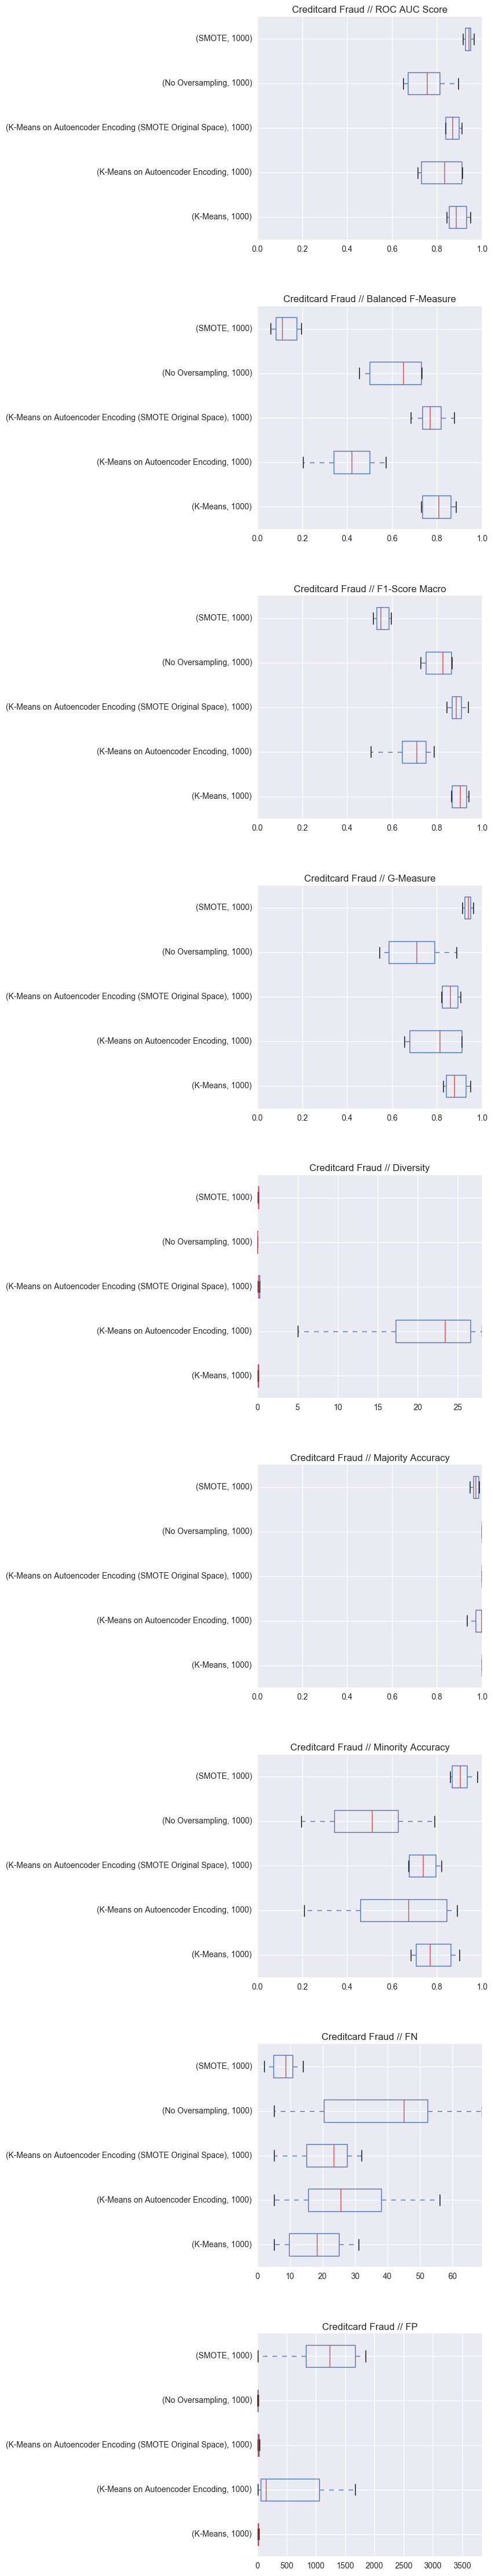

In [15]:
pdf = PdfPages('results/{0}/results.pdf'.format(session_id))
results_to_plot = res[['ROC AUC Score','Balanced F-Measure','F1-Score Macro', 'G-Measure', 'Diversity', 'Majority Accuracy', 'Minority Accuracy', 'FN', 'FP']]
for dataset in res.index.levels[0].values:
    fig,axes = plt.subplots(nrows=len(results_to_plot.columns), ncols=1, figsize=(5,len(results_to_plot.columns)))
    fig.subplots_adjust(top=5, hspace=0.3)
    for i, score in enumerate(results_to_plot.columns):
#         ax=axes[i*2]
#         ax.set_title(dataset + ' // ' + score)
        unstacked_res = results_to_plot[score][dataset].unstack(level=[0,2])
#         mean = unstacked_res.loc[pd.IndexSlice[:,'mean'],:]
#         sd = unstacked_res.loc[pd.IndexSlice[:,'std'],:]
#         mean.index = mean.index.droplevel(1)
#         sd.index = sd.index.droplevel(1)
        maximum = unstacked_res.loc[pd.IndexSlice[:,'max'],:].dropna(axis=1).values.max()
        lim = (0,1) if maximum <= 1 else (0,maximum)
# #         mean.plot(kind='barh',ax=ax, width=.8, xerr=sd, xlim=lim )
#         ax.legend(bbox_to_anchor=(1.9, 1))
#         ax.set_yticklabels([])
#         ax.set_ylabel('')
#         ax.set_yticks(np.arange(0,0.8*3))
        ax=axes[i]
        ax.set_title(dataset + ' // ' + score)
        unstacked_res.plot(kind='box', ax=ax, xlim=lim, vert=False)
#         ax.set_xticklabels([n.get_text()[1:].split(',')[0][0:15] for n in ax.get_xticklabels()])
    pdf.savefig(fig, bbox_inches='tight')
pdf.close()

In [16]:
# res_detailed = pd.read_csv('./results/2017-04-21 22h55m59/results_detailed.csv')
# res_detailed = res_detailed.loc[res_detailed['Oversampling'] == 'K-Means on Autoencoder Encoding']
# ae_err = pd.Series({1:0.5863,2:0.5850,3:0.5852,4:0.5862,5:0.5890}, name='AE Error')
# res_detailed = res_detailed.join(ae_err, on='Fold')

# res_detailed_26_04 = pd.read_csv('./results/2017-04-26 12h12m03/results_detailed.csv')
# res_detailed_26_04 = res_detailed_26_04.loc[res_detailed_26_04['Oversampling'] == 'K-Means on Autoencoder Encoding']
# ae_err_26_04 = pd.Series({1:0.5864,2:0.5853,3:0.5846,4:0.5861,5:0.5883}, name='AE Error')
# res_detailed_26_04 = res_detailed_26_04.join(ae_err_26_04, on='Fold')

# res_detailed = pd.concat([res_detailed,res_detailed_26_04], axis=0)

# display(res_detailed)

# res_detailed = res_detailed.sort_values(by='AE Error') 

# for c in ['Balanced F-Measure','G-Measure','Majority Accuracy','Minority Accuracy','ROC AUC Score']:
#     plt.plot(res_detailed['AE Error'], res_detailed[c], '-o', label=c)
# plt.legend(loc=4)
# plt.title('Relation to AE Error')

# plt.figure(figsize=(3,2))
# pd.Series(res_detailed.corr()['AE Error'], name='Correlation with AE Error').plot.barh(title='Correlation with AE Error')